Here we attempt to understand the topics of conversation surrounding posts to Twitter containing the word "nicotine." The tweets for this analysis were drawn from 09/30/2018 - 10/1/2019 (1 year).
<br><br>

There were **1203466** tweets containing the keyword 'nicotine'. After filtering out retweets, we were left with **417139** tweets.  All non-english tweets were removed leaving **371642** unique tweets.
<br><br>
Posts that contained the keyword 'nicotine' but were found to be unrelated to our research objectives were identified and removed. This included tweets containing the bi-grams **"bad nicotine", "nicotine herion"** **"nicotine stain"** and **"silver spoon"** as these were phrases from song lyrics. After additional filtering, we were left with **364430** tweets.
<br><br>

Next we distinguished between posts from non-bot accounts and social bots. During this process (n=**27186** ), we found that several accounts responsible for posts in our data had been deleted. As such, we removed posts (n=**42890** ) from these accounts. The final sample contained **321540** tweets with **300360** tweets from **181439** unique non-bot accounts and **21180** from **5889** social bots. 

In [1]:
import pandas as pd
import nltk
import string
import matplotlib.pyplot as plt
import re
import langdetect
import math
import tqdm
import itertools as it
from operator import add

from wordcloud import WordCloud
from collections import defaultdict
from nltk.tokenize import sent_tokenize, word_tokenize

In [2]:
pd.set_option('display.max_columns',40)

# Data Preprocessing

<br>

- **Basic normalization:** Lower case all tweets, remove extra spaces, remove punctuation between words, and remove special characters such as brackets, etc.
- **Stop word removal:** Words such as 'a', 'the', etc. are heavily represented in the English language. Such words add to the syntax, but rarely add to the meaning of the sentence. To make analysis easier, we ignore these words.
- **Normalizing twitter user mentions:** In twitter @person_name is used to tag people, and pages in your post. The name of each person tagged has little importance to us, but we would like to maintain statistics on the number of people tagged. Therefore, all @xyz occurrences in the tweets have been replaced by @person - a common token for all people.
- **Lemmatization:** Words such as 'walked', and 'walk' should be conflated in our analysis, so we would like to break down words into their basic form by removing inflections, and variants.
- **Non-printable character removal:** Unicode characters in tweets are often used for emoticons, or as symbols from other languages. Since we are dealing with tweets in English, we can remove these symbols without much loss in the meaning of the sentence.
- **Remove hashtags, and urls in the tweet:** Hashtags are useful for filtering out tweets which relate to a group (like e-juices), but don't add much value when trying to divide the group into topics. URLs embedded in the tweet are usually links to images (which on twitter are shown as embedded images), and external links to other websites. Since not much can be said about a website just from its URL, we can discard it.
- **Remove emojis:** We removed emojis and other non-ASCII characters from the tweets. 


In [3]:
def remove_nonenglish(df):
    '''
        removes non-english tweets from the data
    '''
    en = 0
    flags = []
    for post in tqdm.tqdm(text): 
        try:
            ch = langdetect.detect(post)
            if ch == 'en':
                en +=1
                flags.append(True)
            else:
                flags.append(False)
        except Exception as e:
            if e == Exception.KeyboardInterrupt:
                break
            print(post)
            flags.append(False)
    return df[flags]

stopwords = set(nltk.corpus.stopwords.words('english'))
punctuation = (string.punctuation)
url_regex = re.compile(
    r'^(?:http|ftp)s?://' # http:// or https://
    r'(?:(?:[A-Z0-9](?:[A-Z0-9-]{0,61}[A-Z0-9])?\.)+(?:[A-Z]{2,6}\.?|[A-Z0-9-]{2,}\.?)|' #domain...
    r'localhost|' #localhost...
    r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})' # ...or ip
    r'(?::\d+)?' # optional port
    r'(?:/?|[/?]\S+)$', re.IGNORECASE)
tokenizer = nltk.tokenize.TweetTokenizer()
lemmatizer = nltk.WordNetLemmatizer()
punctuations = set(string.punctuation)

def lemmatizeToken(token, tag):
    '''
        Lemmatizer function. Four tags are considered: nouns, verbs, adjectives and adverbs
    '''
    tag = {
        'N': nltk.corpus.wordnet.NOUN,
        'V': nltk.corpus.wordnet.VERB,
        'R': nltk.corpus.wordnet.ADV,
        'J': nltk.corpus.wordnet.ADJ
    }.get(tag[0], nltk.corpus.wordnet.NOUN)
    return lemmatizer.lemmatize(token, tag)

def normalize_tweets(tweets,lemmatize):
    '''
        Creates one-grams and bi-grams from text data. 
        lemmatize=1 lemmatizes the data.
        Data is also normalized during the process. (removes hashtags, urls, stopwords
        , basic punctuation, non-printable characters)
        normalizes mentions
    '''
    onegrams = defaultdict(lambda:0)
    bigrams = defaultdict(lambda:0)
    onegram_dict = defaultdict(lambda:0)
    bigram_dict = defaultdict(lambda:0)
    loc_onegrams = []
    loc_bigrams = []
    prev = None
    for i in tqdm.trange(len(tweets)):
        tweet = tweets[i]
        lonegram = set()
        lbigram = set()
        tweet = tweet.encode('ascii', 'ignore').decode('ascii')
        for token, tag in nltk.pos_tag(tokenizer.tokenize(tweet.lower())):
            if token[0] == '#' or len(token) < 2 or url_regex.search(token):
                continue
            elif token in stopwords:
                continue
            elif all(char in punctuations for char in token):
                continue
            elif token[0] == '@':
                token = '@person' #Replace all friend tags with a common token.
                tag = 'NNP'
            word = lemmatizeToken(token, tag) if lemmatize else token
            onegrams[word] += 1
            lonegram.add(word)
            #add word location to onegram dictionary
            if word != "nicotine":
                if word not in onegram_dict:
                    onegram_dict[word] = [i]
                elif i != onegram_dict[word][-1]:
                    onegram_dict[word] += [i]
            if prev is not None:
                bigram = '-'.join([prev, word])
                bigrams[bigram] += 1
                lbigram.add(bigram)
                #add bigram location to bigram dictionary
                if bigram not in bigram_dict:
                    bigram_dict[bigram] = [i]
                elif i != bigram_dict[bigram][-1]:
                    bigram_dict[bigram] += [i]
                
            prev = word
        loc_onegrams.append(lonegram)
        loc_bigrams.append(lbigram)
        
    return onegrams,bigrams, onegram_dict, bigram_dict, loc_onegrams, loc_bigrams

def load_data(file_name, non_english=True):
    '''
        opens csv and runs normalize_tweets and generates onegrams and bigrams.
    '''
    df = pd.read_csv(file_name)
    if(non_english):
        df = remove_nonenglish(df)
    tweets = list(df['text'])
    print("Tweets count: ",len(tweets))
    return(normalize_tweets(tweets,1))

In [4]:
def create_wordcloud(freqDict, w=1920, h=1080):
    '''
        Given a word-frequency dictionary, create a word cloud.
    '''
    wc = WordCloud(width=w, height=h,background_color = 'white', max_words=150).generate_from_frequencies(freqDict)
    plt.figure(figsize=(30,30))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

## Generating n-grams

In order to find topics within our tweets, we generate one-grams and bi-grams from each tweet. N-grams that are popular among tweets can help us identify popular topics of discussion. For example, Sentence: "A quick brown fox jumps." one-grams : "a", "quick", "brown", "fox", and "jumps" bi-grams : "a quick", "quick brown", "brown fox", and "fox jumps"


In [5]:
onegrams, bigrams, onegram_dict, bigram_dict, loc_onegram, loc_bigram = load_data("non_bots.csv", non_english=False)

  0%|                                                                                       | 0/300360 [00:00<?, ?it/s]

Tweets count:  300360


100%|█████████████████████████████████████████████████████████████████████████| 300360/300360 [10:02<00:00, 498.27it/s]


In [6]:
onegrams_bot, bigrams_bot, onegram_dict_bot, bigram_dict_bot, loc_onegram_bot, loc_bigram_bot = load_data("bots.csv", non_english=False)

  1%|▍                                                                            | 122/21180 [00:00<00:36, 579.60it/s]

Tweets count:  21180


100%|███████████████████████████████████████████████████████████████████████████| 21180/21180 [00:42<00:00, 503.51it/s]


In [7]:
df = pd.read_csv('non_bots.csv')
text = df['text']
df_bot = pd.read_csv('bots.csv')
text_bot = df_bot['text']

## Exploration through word clouds

By generating word clouds for the most common one-grams and bi-grams we can get a feel of the common topics discussed by people. The word cloud displays the most popular n-grams. More popular n-grams are larger than less popular ones.


### One-gram word cloud

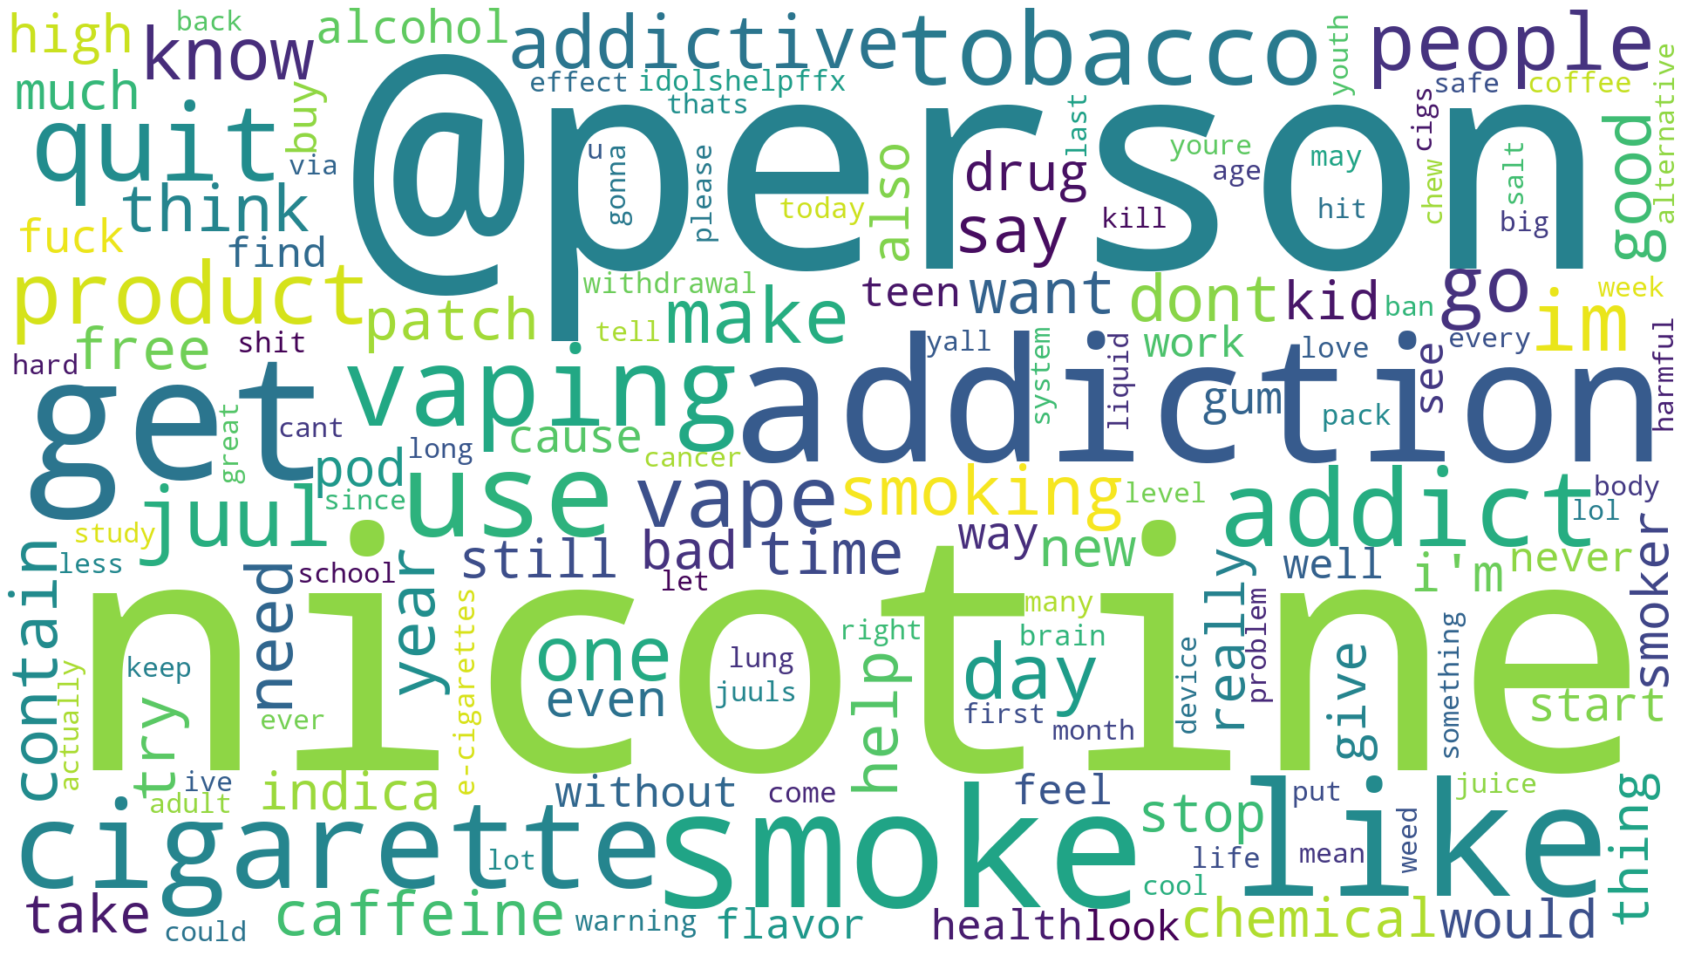

In [8]:
create_wordcloud(onegrams)

#### For bot corpus

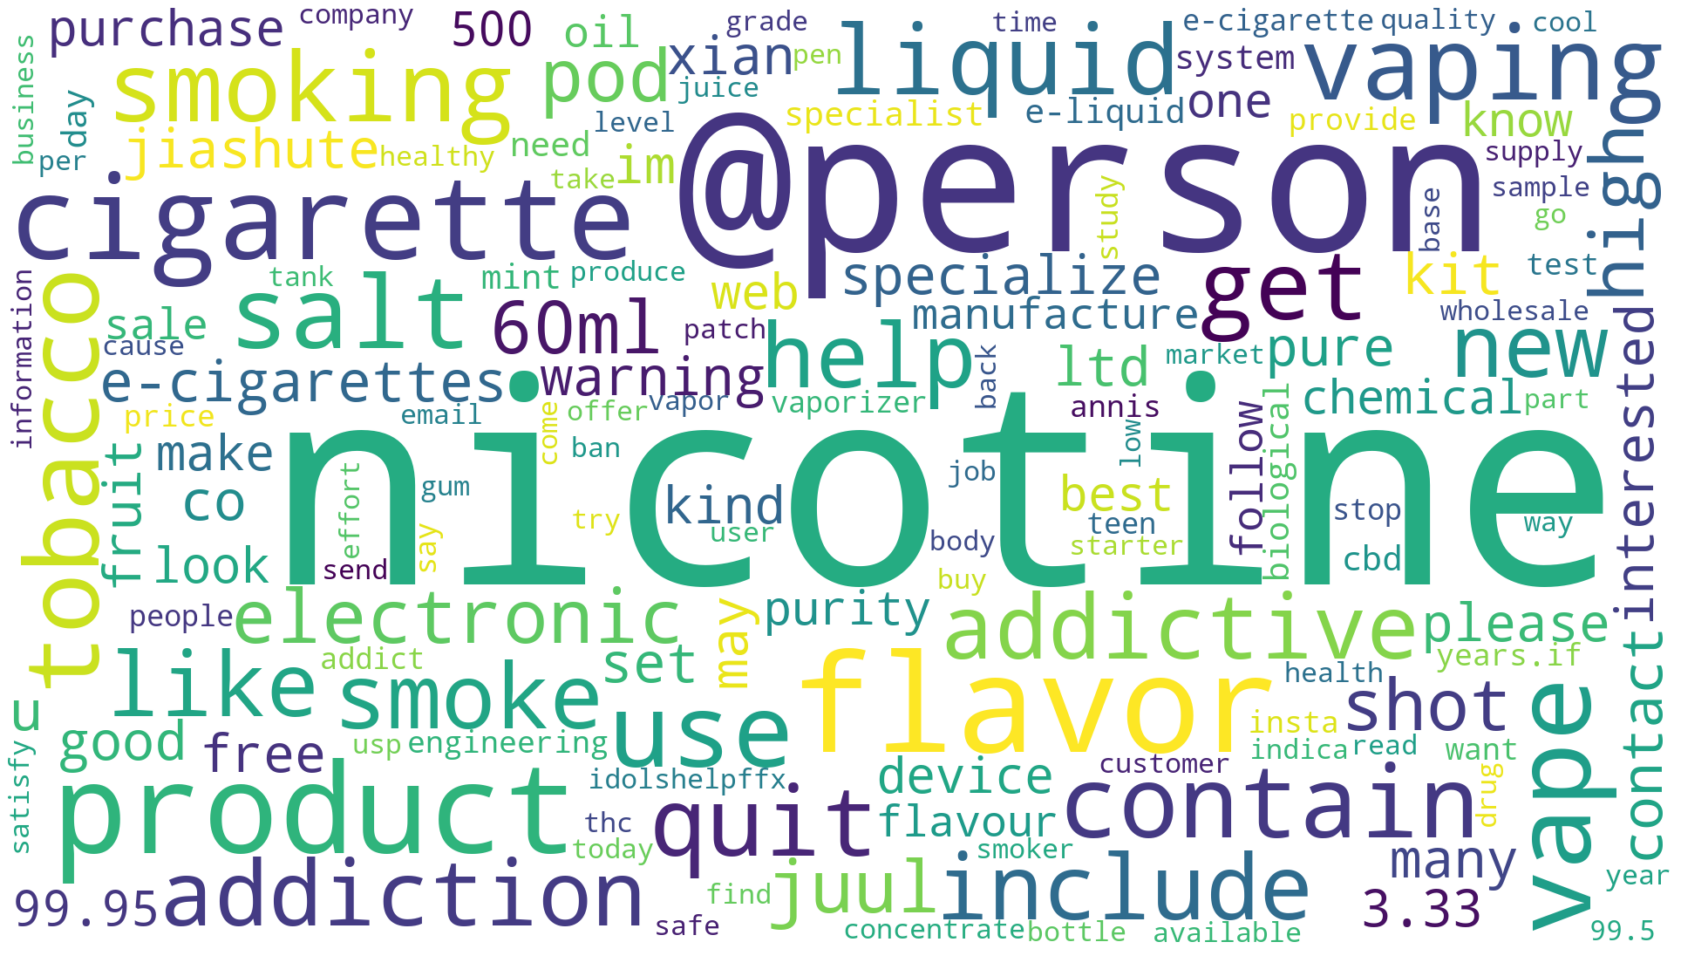

In [9]:
create_wordcloud(onegrams_bot)

### Bi-gram word cloud

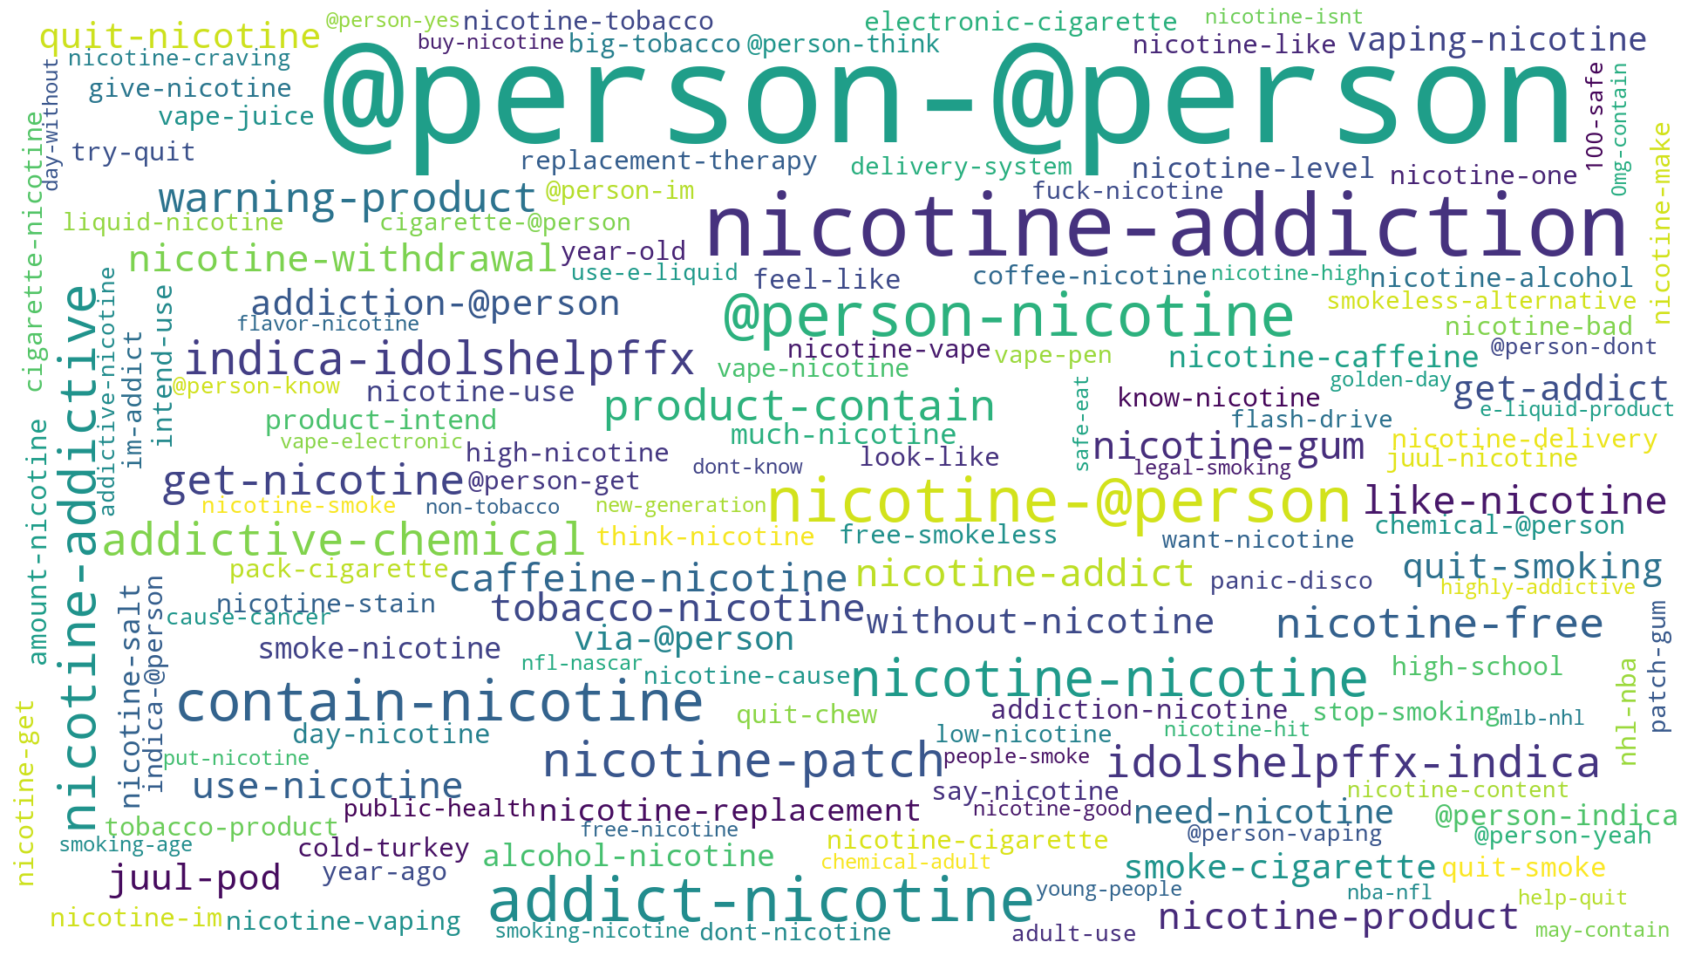

In [10]:
create_wordcloud(bigrams)

#### For bot corpus

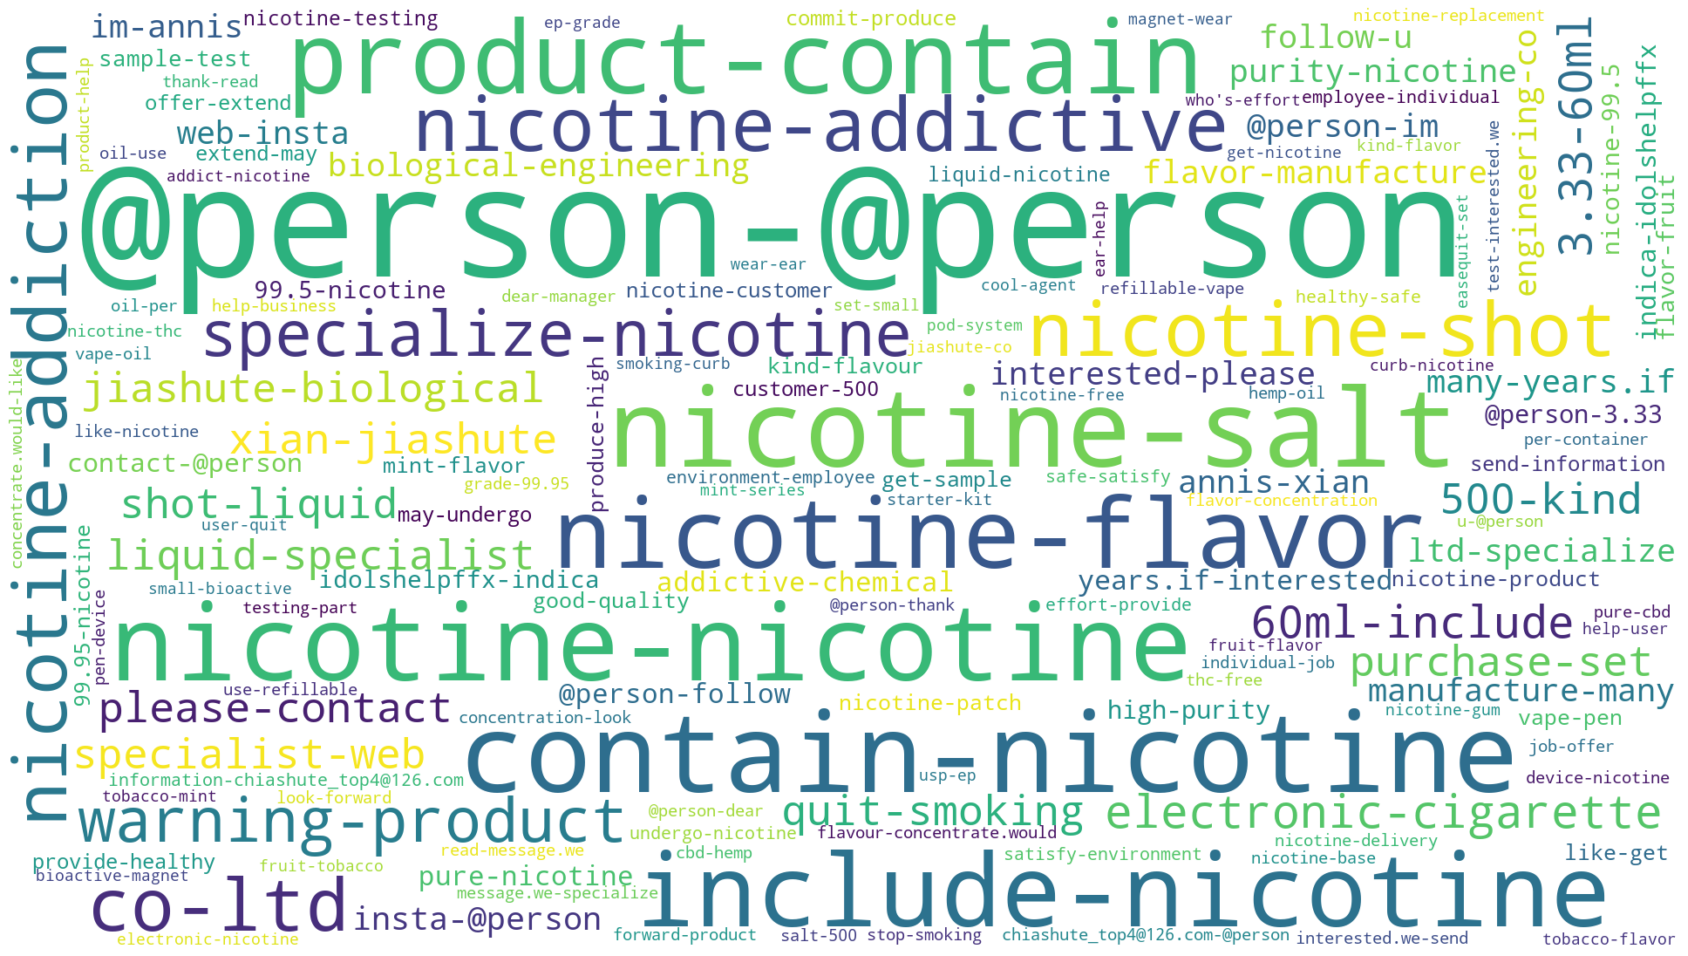

In [11]:
create_wordcloud(bigrams_bot)

One topic that stands out in the bi-gram word cloud is person tagging (bi-grams containing @person). In order to help highlight other topics, let's have a look at a word cloud without it.

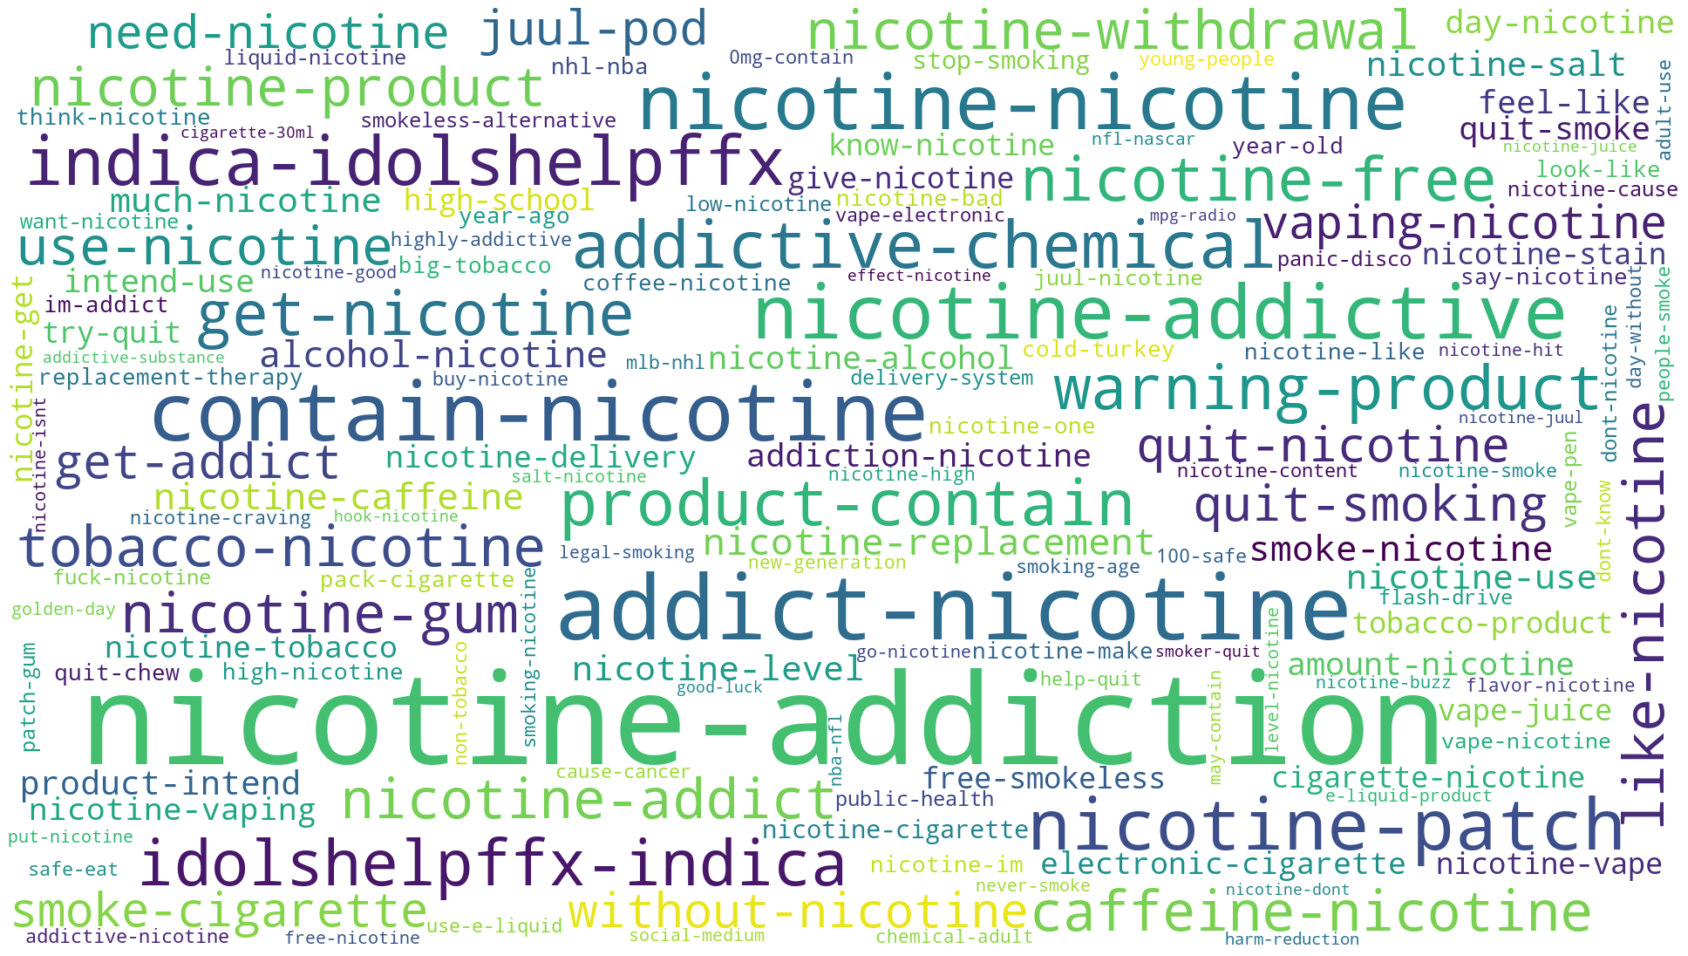

In [12]:
new_keys = []
for key in bigrams.keys():
    if '@person' not in key:
        new_keys.append(key)
create_wordcloud(dict((key, bigrams[key]) for key in new_keys))

## Classify tweets into topics:

From the wordclouds we can identify a few commonly occuring themes. For example, Person-tagging, Purchases, Tobacco Industry, Addiction, Appeal, Non-combustible nicotine delivery, Use of nicotine, etc. 
<br><br>
In order to classify a tweet into a topic we search for a list of n-grams that represent the topic within each tweets. If at least one n-gram matches, the tweet is considered a member of the topic.

We use three patterns to classify tweets:
1. Check if a certain one-gram occurs in the tweet
2. Check if a certain bi-gram occurs in the tweet
3. Check if several onegrams occur together in a tweet. For example, the pattern "Free Day nicotine" will find all sentences that have the onegrams "free", "day" and "nicotine" in any order. 

In [13]:
def classify(search_dict, tweets, loc_onegram, loc_bigram, print_flag = True):
    if 'onegrams' in search_dict.keys():
        search_onegrams = search_dict['onegrams']
    else:
        search_onegrams = []
    
    if 'bigrams' in search_dict.keys():
        search_bigrams = search_dict['bigrams']
    else:
        search_bigrams = []
    
    if 'occurs' in search_dict.keys():
        search_occur = search_dict['occurs']
    else:
        search_occur = []
    result = []
    
    for i in range(len(tweets)):
        lonegram = loc_onegram[i]
        lbigram = loc_bigram[i]
        flag = False
        
        for onegram in search_onegrams:
            if onegram in lonegram:
                result.append(True)
                flag = True
                break
        if(flag):
            continue
        
        for bigram in search_bigrams:
            if bigram in lbigram:
                result.append(True)
                flag = True
                break
        if(flag):
            continue
        
        for occurs in search_occur:
            flag1 = True
            for occ in occurs:
                if occ not in lonegram:
                    flag1 = False
                    break
            if(flag1):
                result.append(True)
                flag = True
                break
        if(not flag):
            result.append(False)
    if(print_flag):
        if(len(result) > 100000):
            print("Non-bot: ")
        else:
            print("Bot: ")
        print("%.2f%% (%i/%i) tweets were matched"%((sum(result)/len(result))*100, sum(result), len(result)))
    return result

In [14]:
result = {}
result_bot = {}

### Person tagging

In [15]:
search_dict = {}
search_dict['onegrams'] = ['@person']
search_dict['bigrams']  = []
search_dict['occurs'] = []

result['person-tagging'] = classify(search_dict, text, loc_onegram, loc_bigram)
result_bot['person-tagging'] = classify(search_dict, text_bot, loc_onegram_bot, loc_bigram_bot)

Non-bot: 
40.27% (120962/300360) tweets were matched
Bot: 
20.47% (4336/21180) tweets were matched


### Addiction

In [16]:
search_dict = {}
search_dict['onegrams'] = ['addiction', 'addict', 'craving']
search_dict['bigrams']  = ['im-addict']
search_dict['occurs'] = []

result['addiction'] = classify(search_dict, text, loc_onegram, loc_bigram)
result_bot['addiction'] = classify(search_dict, text_bot, loc_onegram_bot, loc_bigram_bot)

Non-bot: 
19.85% (59634/300360) tweets were matched
Bot: 
9.22% (1952/21180) tweets were matched


### Appeal

In [17]:
search_dict = {}
search_dict['onegrams'] = []
search_dict['bigrams']  = ['get-nicotine', 'like-nicotine', 'need-nicotine', 'love-nicotine']
search_dict['occurs'] = []

result['appeal'] = classify(search_dict, text, loc_onegram, loc_bigram)
result_bot['appeal'] = classify(search_dict, text_bot, loc_onegram_bot, loc_bigram_bot)

Non-bot: 
4.68% (14061/300360) tweets were matched
Bot: 
2.60% (550/21180) tweets were matched


### Vaping

In [18]:
search_dict = {}
search_dict['onegrams'] = ['salt', 'level', 'vape','vaping','juul','pod']
search_dict['bigrams']  = ['use-eliquid']
search_dict['occurs'] = [['juul', 'pod'], ['electronic', 'cigarette'],['vape', 'juice']]

temp_result = classify(search_dict, text, loc_onegram, loc_bigram,False)
temp_result_bot = classify(search_dict, text_bot, loc_onegram_bot, loc_bigram_bot,False)


search_dict = {}
search_dict['onegrams'] = []
search_dict['bigrams']  = ['much-nicotine']
search_dict['occurs'] = []

temp = classify(search_dict, text, loc_onegram, loc_bigram, False)

for i in range(len(temp)):
    if(temp_result[i]):
        continue
    if(temp[i]):
        if 'too much nicotine' in text[i]:
            temp_result[i] = True

result['vaping'] = temp_result
print("Non-bot: ")
print("%.2f%% (%i/%i) tweets were matched"%((sum(temp_result)/len(temp_result))*100, sum(temp_result), len(temp_result)))

temp = classify(search_dict, text_bot, loc_onegram_bot, loc_bigram_bot, False)

for i in range(len(temp)):
    if(temp_result_bot[i]):
        continue
    if(temp[i]):
        if 'too much nicotine' in text[i]:
            temp_result_bot[i] = True

result_bot['vaping'] = temp_result_bot
print("Bot: ")
print("%.2f%% (%i/%i) tweets were matched"%((sum(temp_result_bot)/len( temp_result_bot))*100, sum(temp_result_bot), len(temp_result_bot)))

Non-bot: 
20.89% (62736/300360) tweets were matched
Bot: 
27.61% (5847/21180) tweets were matched


### NRT

In [19]:
search_dict = {}
search_dict['onegrams'] = ['patch', 'gum', 'product', 'replacement']
search_dict['bigrams'] = ['nicotine-delivery']
result['NRT'] = classify(search_dict, text, loc_onegram, loc_bigram)
result_bot['NRT'] = classify(search_dict, text_bot, loc_onegram_bot, loc_bigram_bot)

Non-bot: 
12.14% (36475/300360) tweets were matched
Bot: 
16.96% (3592/21180) tweets were matched


### Smoking

In [20]:
search_dict = {}
search_dict['onegrams'] = ['smoke', 'cigarette','tobacco']
search_dict['bigrams']  = ['tobacco-product']
search_dict['occurs'] = []

result['smoking'] = classify(search_dict, text, loc_onegram, loc_bigram)
result_bot['smoking'] = classify(search_dict, text_bot, loc_onegram_bot, loc_bigram_bot)

Non-bot: 
20.96% (62956/300360) tweets were matched
Bot: 
18.79% (3980/21180) tweets were matched


### Nicotine Health Risks

In [21]:
search_dict = {}
search_dict['onegrams'] = ['brain', 'chemical', 'lungs']
search_dict['bigrams']  = ['product-intend', 'amount-nicotine', 'intend-use', 'high-nicotine', 
                          'public-health', 'nicotine-cause', 'low-nicotine', 'adult-use', 
                          '@person-dont', 'highly-addictive', 'may-contain']
search_dict['occurs'] = [['warning', 'product']]

result['nicotine-health-risks'] = classify(search_dict, text, loc_onegram, loc_bigram)
result_bot['nicotine-health-risks'] = classify(search_dict, text_bot, loc_onegram_bot, loc_bigram_bot)

Non-bot: 
7.95% (23869/300360) tweets were matched
Bot: 
8.38% (1774/21180) tweets were matched


### Nicotine is safe

In [22]:
search_dict = {}
search_dict['onegrams'] = []
search_dict['bigrams']  = ['isnt-harmful']
search_dict['occurs'] = [['cause', 'cancer']]

result['nicotine-safe'] = classify(search_dict, text, loc_onegram, loc_bigram)
result_bot['nicotine-safe'] = classify(search_dict, text_bot, loc_onegram_bot, loc_bigram_bot)

Non-bot: 
0.50% (1489/300360) tweets were matched
Bot: 
0.18% (38/21180) tweets were matched


### Withdrawal

In [23]:
search_dict = {}
search_dict['onegrams'] = ['withdrawal']
search_dict['bigrams']  = []
search_dict['occurs'] = []

result['withdrawal'] = classify(search_dict, text, loc_onegram, loc_bigram)
result_bot['withdrawal'] = classify(search_dict, text_bot, loc_onegram_bot, loc_bigram_bot)

Non-bot: 
1.88% (5636/300360) tweets were matched
Bot: 
0.85% (181/21180) tweets were matched


### Quit Nicotine

In [24]:
search_dict = {}
search_dict['onegrams'] = ['help', 'quit']
search_dict['bigrams']  = ['quit-chew']
search_dict['occurs'] = [['free', 'day'],['no', 'day'],['give', 'up'],['try', 'quit'],
                        ['cold', 'turkey'], ['day', 'without']]

result['quit-nicotine'] = classify(search_dict, text, loc_onegram, loc_bigram)
result_bot['quit-nicotine'] = classify(search_dict, text_bot, loc_onegram_bot, loc_bigram_bot)

Non-bot: 
10.23% (30724/300360) tweets were matched
Bot: 
9.73% (2061/21180) tweets were matched


### Cessation

In [25]:
search_dict = {}
search_dict['onegrams'] = []
search_dict['bigrams']  = []
search_dict['occurs'] = [['quit', 'smoking'], ['quit', 'smoke'], ['stop', 'smoking']]

search_dict_bot = {}
search_dict_bot['onegrams'] = ['sauna', 'hypnotherapy', 'acupuncture', 'hypnotherapist']
search_dict_bot['bigrams']  = ['more-effective']
search_dict_bot['occurs'] = [['quit', 'smoking'], ['quit', 'smoke'], ['stop', 'smoking'], 
                            ['magnets', 'warn'], ['ear', 'helps']]

result['cessation'] = classify(search_dict, text, loc_onegram, loc_bigram)
result_bot['cessation'] = classify(search_dict_bot, text_bot, loc_onegram_bot, loc_bigram_bot)

Non-bot: 
3.43% (10288/300360) tweets were matched
Bot: 
5.08% (1075/21180) tweets were matched


### Polysubstance use

In [26]:
search_dict = {}
search_dict['onegrams'] = ['alcohol']
search_dict['bigrams']  = []
search_dict['occurs'] = []

result['polysubstance-use'] = classify(search_dict, text, loc_onegram, loc_bigram)
result_bot['polysubstance-use'] = classify(search_dict, text_bot, loc_onegram_bot, loc_bigram_bot)

Non-bot: 
2.66% (7975/300360) tweets were matched
Bot: 
1.20% (254/21180) tweets were matched


### Caffeine and nicotine dependence

In [27]:
search_dict = {}
search_dict['onegrams'] = ['caffeine', 'coffee']
search_dict['bigrams']  = []
search_dict['occurs'] = [['100', 'safe']]

result['caffeine'] = classify(search_dict, text, loc_onegram, loc_bigram)
result_bot['caffeine'] = classify(search_dict, text_bot, loc_onegram_bot, loc_bigram_bot)

Non-bot: 
5.40% (16233/300360) tweets were matched
Bot: 
1.81% (383/21180) tweets were matched


### Underage-use

In [28]:
search_dict = {}
search_dict['onegrams'] = ['kid', 'teen', 'teens', 'youth']
search_dict['bigrams']  = ['smoking-age']
search_dict['occurs'] = [['high', 'school'], ['young', 'people']]

result['underage'] = classify(search_dict, text, loc_onegram, loc_bigram)
result_bot['underage'] = classify(search_dict, text_bot, loc_onegram_bot, loc_bigram_bot)

Non-bot: 
6.89% (20683/300360) tweets were matched
Bot: 
5.00% (1060/21180) tweets were matched


### New Products

In [29]:
search_dict = {}
search_dict['onegrams'] = ['cbd', 'free','pure', 'purity', 'cannatural']
search_dict['bigrams']  = ['nicotine-shot']
search_dict['occurs'] = [['free', 'thc'],['high', 'purity']]

result['new-products'] = classify(search_dict, text, loc_onegram, loc_bigram)
result_bot['new-products'] = classify(search_dict, text_bot, loc_onegram_bot, loc_bigram_bot)

Non-bot: 
4.24% (12747/300360) tweets were matched
Bot: 
14.62% (3096/21180) tweets were matched


# Confusion Matrix

Since our topics overlap with each other, it will be useful to see the percentage of overlap between each topic. A confusion matrix is an useful visualization tool for this purpose.

Each cell in the matrix represents the intersection of two topics. The value of the cell represents the percentage of the total corpus which belong to both topics. For example, in the table below, the cell at the intersection of the **person** column, and **addiction** row represents the tweets which get classified into both categories. The table shows that **5108** tweets i.e. **6.20**% of the total tweets belong to this intersection.

In [30]:
def confusion_matrix(classifications,tweets):
    total_tweets = len(tweets)
    total_classified_tweets = [False for _ in range(len(tweets))]
    for s in list(classifications.values()):
        total_classified_tweets = list(map(lambda x, y: x or y,total_classified_tweets,s))
    total_classified_tweets_len = sum(total_classified_tweets)
    negatives = [i for i, x in enumerate(total_classified_tweets) if not x]
    #print(total_classified_tweets_len)
    answer = []
    for key1 in classifications.keys():
        intersections = [key1]
        for key2 in classifications.keys():
            intersection = list(map(lambda x, y: x and y,classifications[key1],classifications[key2]))
            intersections.append('%s, %0.2f%%' % (sum(intersection), sum(intersection) / total_tweets * 100))
        answer.append(intersections)
    print("Total classified: %0.2f%% (%s/%s)"%(total_classified_tweets_len*100/total_tweets, total_classified_tweets_len, total_tweets))
    return pd.DataFrame(answer, columns=['vs', *classifications.keys()]).set_index('vs'),negatives
    

In [31]:
_,negatives = confusion_matrix(result,loc_onegram)
_

Total classified: 82.86% (248893/300360)


person-tagging      addiction        appeal  \
vs                                                                   
person-tagging         120962, 40.27%   18622, 6.20%   5108, 1.70%   
addiction                18622, 6.20%  59634, 19.85%   2986, 0.99%   
appeal                    5108, 1.70%    2986, 0.99%  14061, 4.68%   
vaping                   26801, 8.92%   11639, 3.88%   2291, 0.76%   
NRT                      15831, 5.27%    2717, 0.90%   1355, 0.45%   
smoking                  28669, 9.54%   11157, 3.71%   2608, 0.87%   
nicotine-health-risks    11036, 3.67%    2729, 0.91%    405, 0.13%   
nicotine-safe             1059, 0.35%     169, 0.06%     32, 0.01%   
withdrawal                1793, 0.60%     611, 0.20%    159, 0.05%   
quit-nicotine            13108, 4.36%    5777, 1.92%    966, 0.32%   
cessation                 4636, 1.54%    1795, 0.60%    378, 0.13%   
polysubstance-use         3787, 1.26%    1245, 0.41%    205, 0.07%   
caffeine                  5074, 1.69%    1522, 0.51%    339, 0.11%   
underage                  9131, 3.04%    6790, 2.26%    497, 0.17%   
new-products              4266, 1.42%     997, 0.33%    302, 0.10%   

                              vaping            NRT        smoking  \
vs                                                                   
person-tagging          26801, 8.92%   15831, 5.27%   28669, 9.54%   
addiction               11639, 3.88%    2717, 0.90%   11157, 3.71%   
appeal                   2291, 0.76%    1355, 0.45%    2608, 0.87%   
vaping                 62736, 20.89%    7397, 2.46%   19746, 6.57%   
NRT                      7397, 2.46%  36475, 12.14%    9972, 3.32%   
smoking                 19746, 6.57%    9972, 3.32%  62956, 20.96%   
nicotine-health-risks    6930, 2.31%    8253, 2.75%    6467, 2.15%   
nicotine-safe             379, 0.13%     165, 0.05%     698, 0.23%   
withdrawal                766, 0.26%     256, 0.09%     899, 0.30%   
quit-nicotine            7854, 2.61%    5683, 1.89%   11673, 3.89%   
cessation                3223, 1.07%    2552, 0.85%    6430, 2.14%   
polysubstance-use         515, 0.17%     338, 0.11%     918, 0.31%   
caffeine                 1088, 0.36%     493, 0.16%    3273, 1.09%   
underage                 8780, 2.92%    3529, 1.17%    6098, 2.03%   
new-products             3456, 1.15%    1528, 0.51%    4785, 1.59%   

                      nicotine-health-risks nicotine-safe   withdrawal  \
vs                                                                       
person-tagging                 11036, 3.67%   1059, 0.35%  1793, 0.60%   
addiction                       2729, 0.91%    169, 0.06%   611, 0.20%   
appeal                           405, 0.13%     32, 0.01%   159, 0.05%   
vaping                          6930, 2.31%    379, 0.13%   766, 0.26%   
NRT                             8253, 2.75%    165, 0.05%   256, 0.09%   
smoking                         6467, 2.15%    698, 0.23%   899, 0.30%   
nicotine-health-risks          23869, 7.95%    690, 0.23%   281, 0.09%   
nicotine-safe                    690, 0.23%   1489, 0.50%     3, 0.00%   
withdrawal                       281, 0.09%      3, 0.00%  5636, 1.88%   
quit-nicotine                   1994, 0.66%    113, 0.04%  1227, 0.41%   
cessation                        714, 0.24%     49, 0.02%   316, 0.11%   
polysubstance-use                417, 0.14%     32, 0.01%   115, 0.04%   
caffeine                         679, 0.23%     82, 0.03%   274, 0.09%   
underage                        3109, 1.04%     67, 0.02%   120, 0.04%   
new-products                     535, 0.18%     35, 0.01%    91, 0.03%   

                       quit-nicotine     cessation polysubstance-use  \
vs                                                                     
person-tagging          13108, 4.36%   4636, 1.54%       3787, 1.26%   
addiction                5777, 1.92%   1795, 0.60%       1245, 0.41%   
appeal                    966, 0.32%    378, 0.13%        205, 0.07%   
vaping                

## Confusion matrix for bot corpus

In [32]:
_,negatives_bot = confusion_matrix(result_bot,loc_onegram_bot)
_

Total classified: 75.56% (16004/21180)


person-tagging    addiction      appeal        vaping  \
vs                                                                            
person-tagging          4336, 20.47%   272, 1.28%   49, 0.23%    995, 4.70%   
addiction                 272, 1.28%  1952, 9.22%  156, 0.74%    415, 1.96%   
appeal                     49, 0.23%   156, 0.74%  550, 2.60%     59, 0.28%   
vaping                    995, 4.70%   415, 1.96%   59, 0.28%  5847, 27.61%   
NRT                       607, 2.87%    96, 0.45%   23, 0.11%    948, 4.48%   
smoking                   800, 3.78%   381, 1.80%  109, 0.51%   1847, 8.72%   
nicotine-health-risks     113, 0.53%   165, 0.78%   10, 0.05%    544, 2.57%   
nicotine-safe              13, 0.06%     5, 0.02%    0, 0.00%     10, 0.05%   
withdrawal                 18, 0.08%    30, 0.14%    1, 0.00%     61, 0.29%   
quit-nicotine             448, 2.12%   443, 2.09%   23, 0.11%    368, 1.74%   
cessation                  80, 0.38%   231, 1.09%   11, 0.05%    127, 0.60%   
polysubstance-use          46, 0.22%    29, 0.14%    6, 0.03%     19, 0.09%   
caffeine                   48, 0.23%    30, 0.14%    8, 0.04%     53, 0.25%   
underage                  106, 0.50%   302, 1.43%    8, 0.04%    611, 2.88%   
new-products             1554, 7.34%    40, 0.19%   12, 0.06%   1054, 4.98%   

                                NRT       smoking nicotine-health-risks  \
vs                                                                        
person-tagging           607, 2.87%    800, 3.78%            113, 0.53%   
addiction                 96, 0.45%    381, 1.80%            165, 0.78%   
appeal                    23, 0.11%    109, 0.51%             10, 0.05%   
vaping                   948, 4.48%   1847, 8.72%            544, 2.57%   
NRT                    3592, 16.96%    866, 4.09%           1059, 5.00%   
smoking                  866, 4.09%  3980, 18.79%            246, 1.16%   
nicotine-health-risks   1059, 5.00%    246, 1.16%           1774, 8.38%   
nicotine-safe             11, 0.05%     21, 0.10%             16, 0.08%   
withdrawal                 3, 0.01%     19, 0.09%              7, 0.03%   
quit-nicotine            714, 3.37%    459, 2.17%             89, 0.42%   
cessation                354, 1.67%    309, 1.46%             51, 0.24%   
polysubstance-use         14, 0.07%     25, 0.12%             21, 0.10%   
caffeine                  11, 0.05%     60, 0.28%             23, 0.11%   
underage                 167, 0.79%    316, 1.49%             99, 0.47%   
new-products             198, 0.93%    577, 2.72%             20, 0.09%   

                      nicotine-safe  withdrawal quit-nicotine    cessation  \
vs                                                                           
person-tagging            13, 0.06%   18, 0.08%    448, 2.12%    80, 0.38%   
addiction                  5, 0.02%   30, 0.14%    443, 2.09%   231, 1.09%   
appeal                     0, 0.00%    1, 0.00%     23, 0.11%    11, 0.05%   
vaping                    10, 0.05%   61, 0.29%    368, 1.74%   127, 0.60%   
NRT                       11, 0.05%    3, 0.01%    714, 3.37%   354, 1.67%   
smoking                   21, 0.10%   19, 0.09%    459, 2.17%   309, 1.46%   
nicotine-health-risks     16, 0.08%    7, 0.03%     89, 0.42%    51, 0.24%   
nicotine-safe             38, 0.18%    0, 0.00%      2, 0.01%     1, 0.00%   
withdrawal                 0, 0.00%  181, 0.85%     95, 0.45%    24, 0.11%   
quit-nicotine              2, 0.01%   95, 0.45%   2061, 9.73%   885, 4.18%   
cessation                  1, 0.00%   24, 0.11%    885, 4.18%  1075, 5.08%   
polysubstance-use          1, 0.00%    0, 0.00%     29, 0.14%     5, 0.02%   
caffeine                   1, 0.00%   13, 0.06%     58, 0.27%     4, 0.02%   
underage                   1, 0.00%    6, 0.03%    106, 0.50%    21, 0.10%   
new-products               2, 0.01%    5, 0.02%    101, 0.48%    50, 0.24%   

                      polysubstance-use    caffeine     underage  new-produ

# Comparison of non-bot topics and bot topics

The likes and retweets on the tweets were fetched to understand user engagement. As some of the tweets were removed, we could only fetch like and retweet count for 245121/300360 non-bot tweets and 16730/21180 bot tweets

In [33]:
def get_retweet_likes(ids, retweet_like_df):
    fav_list = list(retweet_like_df['fav_count'])
    retweet_list = list(retweet_like_df['retweet_count'])
    ids = [i for i, x in enumerate(ids) if x]
    likes, post_count, retweets = 0, 0, 0
    for i in ids:
        if(not math.isnan(fav_list[i])):
            likes += fav_list[i]
            retweets += retweet_list[i]
            post_count += 1
            
    return int(likes), int(retweets)
    

Non-Bots       Bots      Delta  Total Likes Non-Bots  \
Topics                                                                         
NRT                    12.143761  16.959396  -4.815635                225786   
addiction              19.854175   9.216242  10.637933                907288   
appeal                  4.681382   2.596789   2.084593                119062   
caffeine                5.404515   1.808310   3.596205                 74508   
cessation               3.425223   5.075543  -1.650320                144940   
new-products            4.243907  14.617564 -10.373656                 58411   
nicotine-health-risks   7.946797   8.375826  -0.429029                109477   
nicotine-safe           0.495738   0.179415   0.316324                  4579   
person-tagging         40.272340  20.472144  19.800196                249973   
polysubstance-use       2.655147   1.199245   1.455903                 46374   
quit-nicotine          10.229058   9.730878   0.498180                314352   
smoking                20.960181  18.791313   2.168869                346329   
underage                6.886070   5.004721   1.881349                168498   
vaping                 20.886936  27.606232  -6.719297                365641   
withdrawal              1.876415   0.854580   1.021835                 26800   

                       Total Likes Bots  Total Retweet Non-Bots  \
Topics                                                            
NRT                                1017                   51927   
addiction                          2543                  172691   
appeal                              363                   18606   
caffeine                            138                   14367   
cessation                           320                   35733   
new-products                        561                    8095   
nicotine-health-risks               494                   28402   
nicotine-safe                        17                    1137   
person-tagging                     1361                   44699   
polysubstance-use                    71                    6363   
quit-nicotine                       646                   56349   
smoking                            1968                   75487   
underage                            301                   35246   
vaping                             2427                   72943   
withdrawal                           93                    2719   

                       Total Retweet Bots  
Topics                                     
NRT                                   760  
addiction                             471  
appeal                                 64  
caffeine                               29  
cessation                              93  
new-products                          156  
nicotine-health-risks                 539  
nicotine-safe                           4  
person-tagging                        229  
polysubstance-use                      23  
quit-nicotine                         215  
smoking                               640  
underage                              107  
vaping                                900  
withdrawal                             18

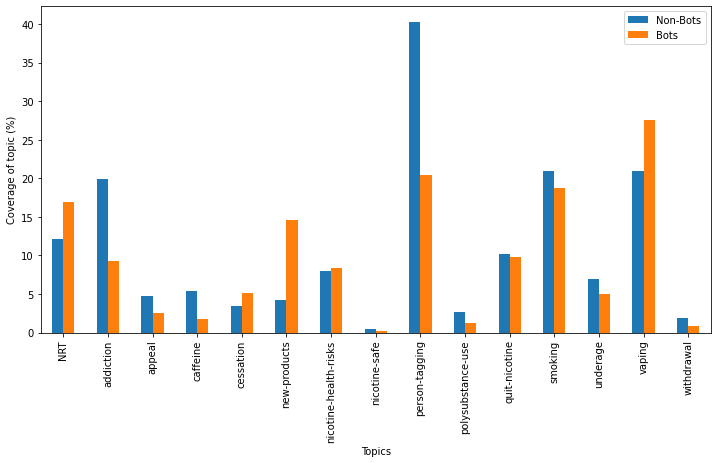

In [34]:
def compare_topics(non_bot_topics, bot_topics, non_bot_tweets, bot_tweets):
    total_bot_tweets = len(bot_tweets)
    total_non_bot_tweets = len(non_bot_tweets)
    
    bot_retweet = pd.read_csv("bots_retweet_likes.csv")
    non_bot_retweet = pd.read_csv("non_bots_retweet_likes.csv")
    
    table = []
    all_topics = sorted(list(set(bot_topics.keys()) | set(non_bot_topics.keys())))
    for topic in all_topics:
        row = [topic, 0, 0, 0, 0, 0, 0, 0]
        if topic in non_bot_topics:
            row[1] = sum(non_bot_topics[topic]) / total_non_bot_tweets * 100
            row[4], row[6] = get_retweet_likes(non_bot_topics[topic], non_bot_retweet)
        if topic in bot_topics:
            row[2] = sum(bot_topics[topic]) / total_bot_tweets * 100
            row[5], row[7] = get_retweet_likes(bot_topics[topic], bot_retweet)
        row[3] = row[1] - row[2]
        table.append(row)
    df = pd.DataFrame(table, columns=['Topics', 'Non-Bots', 'Bots', 'Delta', "Total Likes Non-Bots", "Total Likes Bots", "Total Retweet Non-Bots", "Total Retweet Bots"]).set_index('Topics')
    display(df)
    ax = df[['Non-Bots', 'Bots']].plot(kind='bar', figsize=(12, 6))
    ax.set_ylabel('Coverage of topic (%)')
    display(ax)

compare_topics(result, result_bot, loc_onegram, loc_onegram_bot)

# Remaining Tweets

Below is the word cloud from the remaining tweets (tweets that weren't already classified into a topic). This should help us identify new topics that have been missed.

In [35]:
unclassified_non_bot = [loc_onegram[i] for i in negatives] 
unclassified_bot = [loc_onegram_bot[i] for i in negatives_bot]

In [36]:
def make_freq_dict(onegrams):
    d= {}
    for s in onegrams:
        for w in s:
            if(w not in d.keys()):
                d[w] = 0
            else:
                d[w]+=1
    return d;

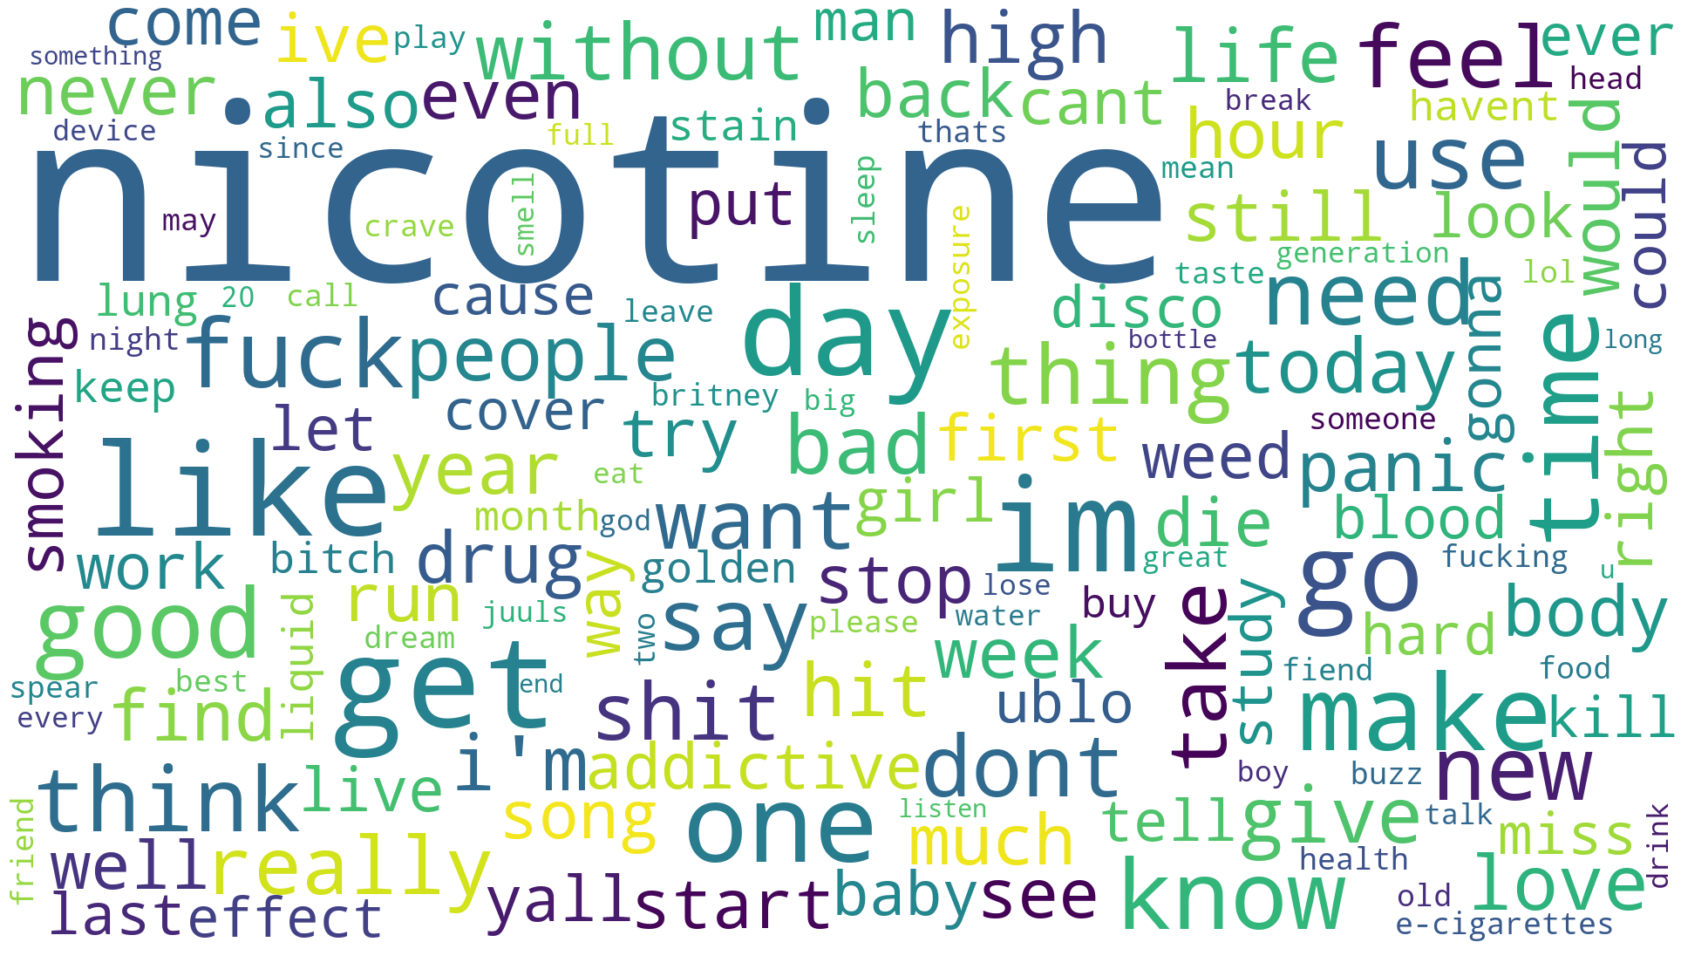

In [37]:
create_wordcloud(make_freq_dict(unclassified_non_bot))

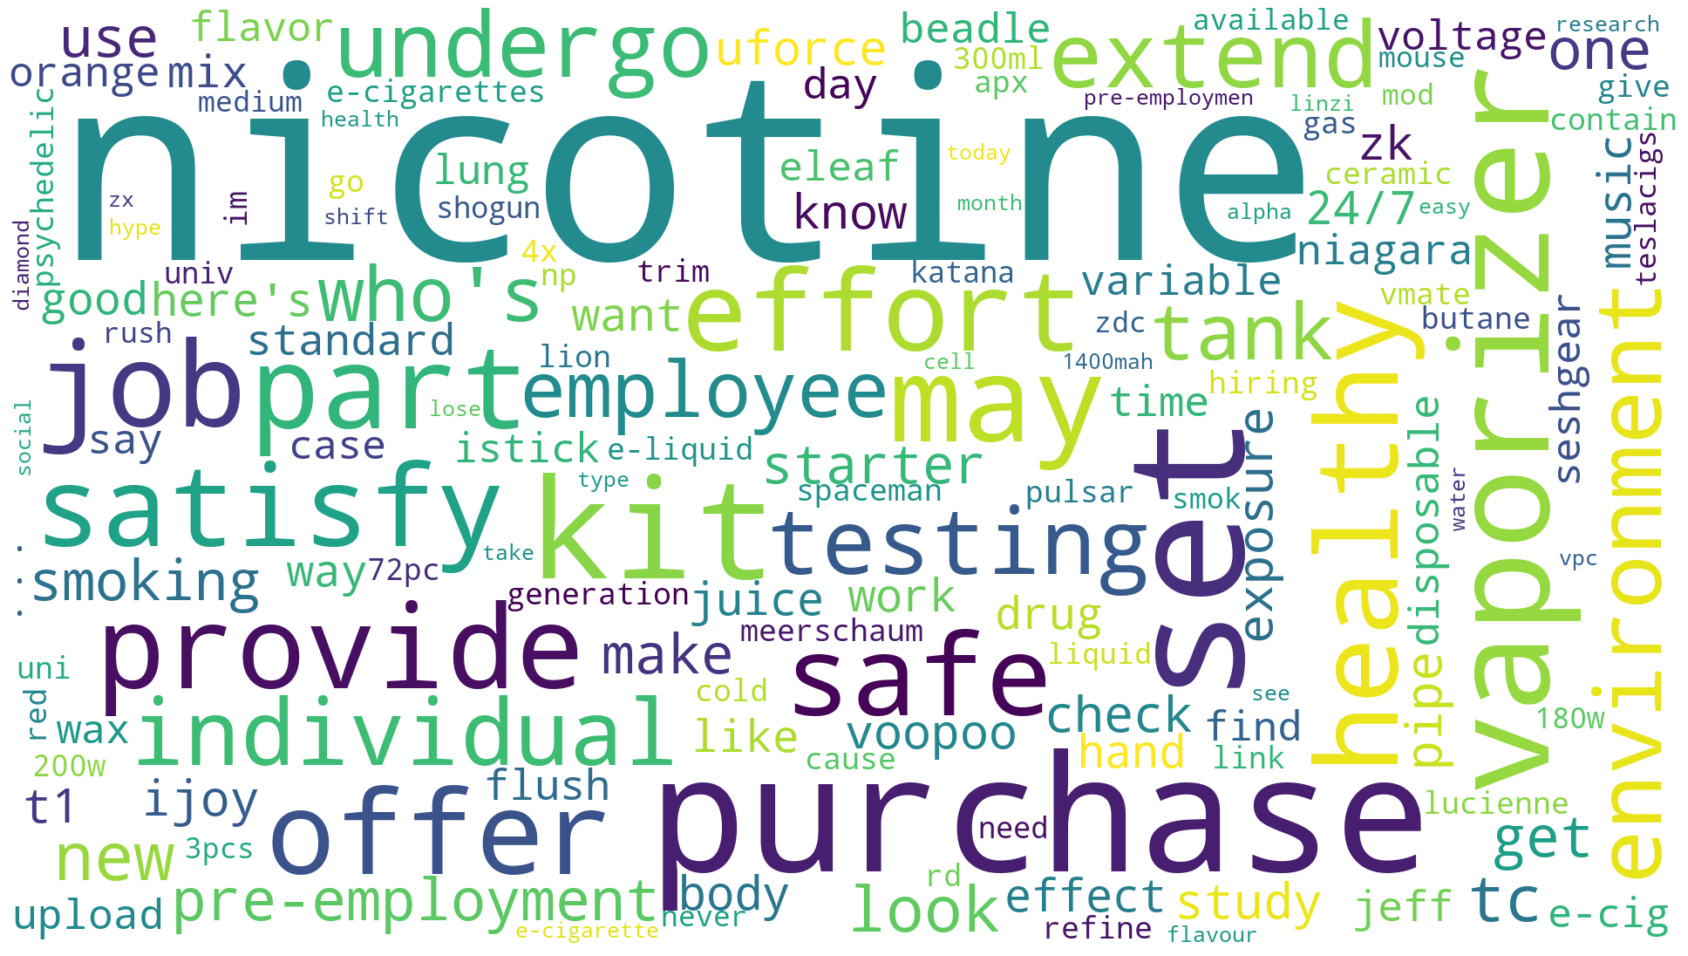

In [38]:
create_wordcloud(make_freq_dict(unclassified_bot))